__Нейросетевая языковая модель на основе LSTM__ 

Евгений Борисов <esborisov@sevsu.ru>

---

# загружаем тексты

In [1]:
import gzip
import requests
from bs4 import BeautifulSoup

In [2]:
url='http://lib.ru/NEWPROZA/LOBAS/taxisty.txt'
text = BeautifulSoup(requests.get(url).text).get_text()
with gzip.open('taxisty.txt.gz','wt') as f: f.write(text)

# with gzip.open('taxisty.txt.gz','rt') as f: text = f.read()

text = text[1030:-7261].strip() # выкидываем заголовок и хвост страницы 
print(f'символов:{len(text)}\n---------------\n'%())
print(text[:343])

символов:637765
---------------

Вы прилетели в  Нью-Йорк и  остановились  в  одном  из отелей, глядящих
окнами на Центральный парк.  Наутро по  приезде вы вышли из  отеля, вдохнули
полной грудью очищенный зеленью парка воздух  и,  взглянув на часы, --  пора
было начинать хлопотливый день, --  направились к  первому из  таксомоторов,
выстроившихся вереницей у подъезда.
    


In [3]:
# url='http://az.lib.ru/d/dostoewskij_f_m/text_0080.shtml'
# text = BeautifulSoup(requests.get(url).text).get_text()
# with gzip.open('dostoewskij.txt.gz','wt') as f: f.write(text)

# # with gzip.open('dostoewskij.txt.gz','rt') as f: text = f.read()

# text = text[2876:-664184].strip() # выкидываем заголовок и хвост страницы 
# print(f'символов:{len(text)}\n---------------\n'%())
# print(text[:355])

---

In [4]:
# !pip install torch

In [5]:
import torch
import numpy as np
# import torchtext
# from torchtext.data import get_tokenizer

In [6]:
from nltk import __version__ as nltk_version
print('nltk version:',nltk_version)

nltk version: 3.8.1


In [7]:
from tqdm.auto import tqdm

from itertools import chain

from nltk.tokenize import sent_tokenize as nltk_sentence_split
from nltk.tokenize import word_tokenize as nltk_tokenize_word
from nltk.util import ngrams

from torch.utils.data import Dataset
import torch.nn.functional as F

In [8]:
class ContextDataset(Dataset):
    
    def __init__(self, text, context_len=5):
        assert context_len>1
        assert len(text)>1
        
        self._context_len = context_len
        self._sentences = [ 
            nltk_tokenize_word(s,language='russian') # разбиваем предложения на слова
            for s in tqdm(nltk_sentence_split(text,language='russian')) # режем текст на отдельные предложения
        ]
        self._tokens = ['<UNK>','<EOS>',]
        self._vocabulary = self._build_vocabulary(self._sentences)
        self._sentences = [ s + [ '<EOS>' ] for s in self._sentences if len(s)> self._context_len ]
        self._data = self._encode_ngrams( self._build_ngrams(self._sentences) )
        
    def _build_vocabulary(self,sentences):        
        text_tokens = self._tokens+sorted( set(chain(*sentences)) ) # собираем все токены (слова) из текста
        vocabulary = { w:n for n,w in enumerate(text_tokens) }
        return vocabulary
    
    def _build_ngrams(self, sentences):
        return [ 
            ng for s in tqdm(sentences)  for ng in ngrams( s, self._context_len+1 ) 
        ]
    
    def _encode_ngrams(self,ngrams):
        return torch.tensor([ self.encode(ng) for ng in tqdm(ngrams) ], dtype=torch.long ) 
    
    
    def __getitem__(self, idx):
        return (
            self._data[idx,:-1],
            # self._data[idx,-1]
            F.one_hot( self._data[idx,-1], num_classes=len(self._vocabulary)).to( torch.float32 ) 
        )
        
    def __len__(self): return len(self._data)
    
    @property
    def vocabulary(self): return self._vocabulary
    
    @property
    def sentences(self): return self._sentences
        
    def encode(self,s): return [ 
            self._vocabulary[w] if (w in self._vocabulary) else self._tokens['<UNK>']
            for w in s 
        ]

In [9]:
ds = ContextDataset(text)

  0%|          | 0/6650 [00:00<?, ?it/s]

  0%|          | 0/5382 [00:00<?, ?it/s]

  0%|          | 0/90648 [00:00<?, ?it/s]

In [11]:
display(len(ds))
display(len(ds.sentences))
display(len(ds.vocabulary))
display(max(ds.vocabulary.values()))

90648

5382

24068

24067

In [12]:
# x,t = ds[:3]
# display(x.shape)
# display(t.shape)

In [13]:
assert len(ds.vocabulary)== max(ds.vocabulary.values())+1

In [14]:
# ds.vocabulary

In [15]:
# x,t = ds[:7]
# display( x.shape,t.shape )

In [16]:
# display( ds.sentences[2] )

# модель

In [17]:
import torch.nn as nn
import torch.nn.functional as F

In [18]:
class Model(nn.Module):
    
    def __init__(self, vocab_len, embedding_len=256, hidden_dim=1024,):
        super().__init__()
        self._embeddings = nn.Embedding( vocab_len, embedding_len )
        # рекуррентный слой
        self._lstm = nn.LSTM( input_size=embedding_len, hidden_size=hidden_dim, batch_first=True ) 
        self._linear = nn.Linear( hidden_dim, vocab_len ) # выходной (линейный) слой
        self._softmax = nn.Softmax(dim=1)

    def forward(self,x):
        o = self._embeddings(x)
        _,(h,_) = self._lstm(o) # обрабатываем входную последовательность
        h = h.squeeze(0) # прекомпоновка тензора, сокращаем размерность
        o = self._linear(h) # считаем выход сети
        o = self._softmax(o)
        return o
    
    def predict(self,x):
        return torch.argmax(self.forward(x),dim=1)

# обучаем модель

In [19]:
# проверяем GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
display( device )
display( torch.cuda.get_device_name() )

device(type='cuda', index=0)

'Tesla P40'

In [20]:
# display( len(ds.vocabulary) )
# display( max(ds.vocabulary.values()) )

In [21]:
# del model

In [22]:
model = Model(vocab_len=len(ds.vocabulary)).to(device)

In [23]:
# ф-ция потери
# criterion =  nn.MSELoss()
criterion =  nn.BCELoss()
# criterion =  nn.CrossEntropyLoss() 
# criterion =  nn.NLLLoss() 
optimizer = torch.optim.Adam( model.parameters(), lr=1e-3) # метод оптимизации

In [24]:
from torch.utils.data import DataLoader

In [25]:
loss_history = [] # значения ф-ции потери

In [80]:
%%time

n_epoch = 2 # количество эпох обучения

for i in tqdm(range(n_epoch)): 
    loss_batch = []
    # получаем батч учебных примеров
    for x,t in DataLoader( ds, batch_size=128, shuffle=True): 
        o = model.forward(x.to(device)) # считаем выход модели
        loss = criterion( o, t.to(device) ) # вычисляем значение ф-ции потери
        loss_batch.append( loss.item() ) # дополняем историю изменения значений ф-ции потери на батче
        optimizer.zero_grad() # очищаем предыдущее значение градиента
        loss.backward()  # вычисляем текущее значение градиента ф-ции потери
        optimizer.step() # корректируем параметры модели
    
    loss_history.append( np.mean(loss_batch) ) # дополняем общую историю изменения значений ф-ции потери

  0%|          | 0/2 [00:00<?, ?it/s]

CPU times: user 26.4 s, sys: 42.6 ms, total: 26.4 s
Wall time: 26.4 s


Text(0.5, 1.0, 'min loss: 0.00004')

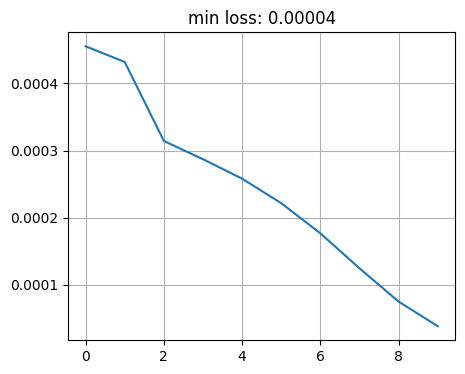

In [81]:
from matplotlib import pyplot as plt

fig,ax = plt.subplots(figsize=(5,4))
ax.plot(loss_history)
ax.grid()
ax.set_title(f'min loss: {min(loss_history):.5f}')

# тестируем

In [85]:
class Generator:
    
    def __init__(self,model,vocabulary,device,context_len=5):
        self._model = model
        self._vocabulary = vocabulary
        self._vocabulary_inv = { v:k for k,v in vocabulary.items() }
        self._device = device
        self._context_len = context_len
      
    def predict(self,prompt,seq_limit=10):
        s = prompt
        for _ in range(seq_limit):
            w = self._vocabulary_inv[ self._predict(s) ]
            s = s + ' ' + w
            if w=='<EOS>':break
        return s
        
    def _predict(self,prompt):
        x = self._encode(prompt)
        with torch.set_grad_enabled(False): 
            p = self._model.predict(x.to(device)).cpu()
        return p.item()    
    
    def _encode(self,s):
        s = nltk_tokenize_word(s,language='russian')[-self._context_len:]
        s = [ self._vocabulary[w] for w in s if (w in self._vocabulary) ]
        return torch.tensor([s], dtype=torch.long )

In [86]:
from random import sample
from nltk.util import ngrams 

context_len = 5

prompts = [
    ' '.join(ng) 
    for s in sample( ds.sentences,10 ) 
    if len(s[:-3])>context_len
    for ng in list(ngrams(s[:context_len],5))  
]


In [87]:
for prompt in prompts:
    t = Generator(model,ds.vocabulary,device).predict(prompt)
    print(prompt,'-->', t[len(prompt):],'\n')

Одни -- индивидуальными , а -->  другие -- '' мини '' Кингс-госпиталь '' Метрополитен '' Метрополитен 

-- Не спорь , я -->  лучше знаю ... Это мои колебания , но все-таки кивнет 

-- властным жестом приказала `` -->  регулировщица '' Метрополитен '' Метрополитен '' Метрополитен '' Метрополитен '' 

Сворачивая на Девятнадцатую улицу , -->  я глянул еще раз в зеркало заднего обзора , проверяя 

Четырех покупателей обслужил и не -->  дал ни одного пластикового мешочка ! .. <EOS> 

Выслушав мои ответы , незнакомка -->  сказала , что , по-видимому , на самом деле , 

Сидя в своем безоконном гаражном -->  закутке , откуда он знал , где мы привыкли видеть 

-- Да , пожалуйста ... -->  -- Куда едете ? <EOS> 

Правило действовало одно : можешь -->  помочь -- помоги ... С белых фаянсовых овалов , укрепленных 



----

----

In [ ]:

# prompt = 'по приезде вы вышли из  отеля, вдохнули'
# prompt = 'несколько издалека, а именно некоторыми биографическими подробностями'
# prompt = 'несколько издалека, а именно некоторыми'
# prompt = 'несколько издалека, а именно'
# prompt = 'некоторыми биографическими'
# prompt = 'из  выстроившихся вереницей'

In [ ]:
# n = 5
# m = 9

# with torch.set_grad_enabled(False):
#     x = torch.randn(n,m)
#     t = torch.rand(n,m)
#     # t = torch.randint(0,m,size=(n,1))
#     o = nn.BCELoss()( nn.Sigmoid()(x), t )

# display(o)

In [ ]:
# # rnn = nn.GRU(10, 20, 2)
# # input = torch.randn(5, 3, 10)
# # h0 = torch.randn(2, 3, 20)
# # output, hn = rnn(input, h0)

# # input_size, hidden_size, num_layers=1,

# n_samples = 2
# len_seq = 3
# layer_size = 5

# with torch.set_grad_enabled(False):
#     x = torch.randn(n_samples,len_seq,layer_size)
#     o,h = nn.GRU( input_size=layer_size, hidden_size=3, num_layers=1,)(x)
#     # o,(h,c) = nn.LSTM( input_size=m, hidden_size=5, num_layers=1,)(x)
    
    
# display(x.shape)
# display(o.shape)
# display(o[:,-1].shape)

# # display(h.shape)

# # display(o)

---

In [ ]:
# class GRUNet(nn.Module):
#     def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
#         super(GRUNet, self).__init__()
#         self.hidden_dim = hidden_dim
#         self.n_layers = n_layers
        
#         self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
#         self.fc = nn.Linear(hidden_dim, output_dim)
#         self.relu = nn.ReLU()
        
#     def forward(self, x, h):
#         out, h = self.gru(x, h)
#         out = self.fc(self.relu(out[:,-1]))
#         return out, h
    
#     def init_hidden(self, batch_size):
#         weight = next(self.parameters()).data
#         hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
#         return hidden

In [ ]:
# class LSTMNet(nn.Module):
#     def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
#         super(LSTMNet, self).__init__()
#         self.hidden_dim = hidden_dim
#         self.n_layers = n_layers
        
#         self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
#         self.fc = nn.Linear(hidden_dim, output_dim)
#         self.relu = nn.ReLU()
        
#     def forward(self, x, h):
#         out, h = self.lstm(x, h)
#         out = self.fc(self.relu(out[:,-1]))
#         return out, h
    
#     def init_hidden(self, batch_size):
#         weight = next(self.parameters()).data
#         hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
#                   weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
#         return hidden

-----

In [ ]:
# class Model(nn.Module):
    
#     def __init__(self, vocab_len, embedding_len=256, hidden_dim=1024,):
#         super().__init__()
#         self._embeddings = nn.Embedding( vocab_len, embedding_len )
#         # рекуррентный слой
#         self._lstm = nn.LSTM( input_size=embedding_len, hidden_size=hidden_dim, batch_first=True ) 
#         self._linear = nn.Linear( hidden_dim, vocab_len ) # выходной (линейный) слой

#     def forward(self,x):
#         o = self._embeddings(x)
#         o,_ = self._lstm(o) # обрабатываем входную последовательность
#         o = o[:,-1]
#         o = self._linear(o) # считаем выход сети
#         o = F.softmax(o,dim=1)
#         return o
    
#     def predict(self,x):
#         return torch.argmax(self.forward(x),dim=1)

In [ ]:
# class Model(nn.Module):
    
#     def __init__(self, vocab_len, embedding_len=256, hidden_dim=1024,):
#         super().__init__()
#         self._embeddings = nn.Embedding( vocab_len, embedding_len )
#         # рекуррентный слой
#         self._lstm = nn.LSTM( input_size=embedding_len, hidden_size=hidden_dim, batch_first=True ) 
#         self._linear = nn.Linear( hidden_dim, vocab_len ) # выходной (линейный) слой

#     def forward(self,x):
#         o = self._embeddings(x)
#         _,(h,_) = self._lstm(o) # обрабатываем входную последовательность
#         h = h.squeeze(0) # прекомпоновка тензора, сокращаем размерность
#         o = self._linear(h) # считаем выход сети
#         o = self._linear(o) # считаем выход сети
#         o = F.softmax(o,dim=1)
#         # o = F.log_softmax(o,dim=1)
#         return o
    
#     def predict(self,x):
#         return torch.argmax(self.forward(x),dim=1)

In [ ]:
# x = torch.randint(0,len(ds.vocabulary),size=(2,3))
# display(x)

# with torch.set_grad_enabled(False):
#     o = Model( vocab_len=len(ds.vocabulary) ).forward(x)
    
# display(o.shape) 
# display(o)    

In [ ]:
# class Generator:
    
#     def __init__(self,model,vocabulary,device):
#         self._model = model
#         self._vocabulary = vocabulary
#         self._vocabulary_inv = { v:k for k,v in vocabulary.items() }
#         self._device = device
      
#     def predict(self,prompt,seq_limit=10):
#         s = prompt
#         for _ in range(seq_limit):
#             w = self._vocabulary_inv[ self._predict(s) ]
#             s = s + ' ' + w
#             if w=='<EOS>':break
#         return s
        
#     def _predict(self,prompt):
#         x = self._encode(prompt)
#         with torch.set_grad_enabled(False): 
#             p = self._model.predict(x.to(device)).cpu()
#         return p.item()    
#         # return torch.argmax(p).item()    
    
#     def _encode(self,s):
#         return torch.tensor( [[ 
#                 self._vocabulary[w] if (w in self._vocabulary) else self._vocabulary['<UNK>']
#                 for w in nltk_tokenize_word(s,language='russian') 
#             ]], dtype=torch.long )
    

In [ ]:
# class Model(nn.Module):
    
#     def __init__(self, vocab_len, embedding_len=256, hidden_dim=1024,):
#         super().__init__()
#         self._embeddings = nn.Embedding( vocab_len, embedding_len )
#         # рекуррентный слой
#         self._rnn = nn.GRU( input_size=embedding_len, hidden_size=hidden_dim, batch_first=True, num_layers=2, ) 
#         self._linear = nn.Linear( hidden_dim, vocab_len ) # выходной (линейный) слой
#         self._softmax = nn.Softmax(dim=1)

#     def forward(self,x):
#         o = self._embeddings(x)
#         o,_ = self._rnn(o) # обрабатываем входную последовательность
#         o = o[:,-1]
#         o = self._linear(o) # считаем выход сети
#         o = self._softmax(o)
#         return o
    
#     def predict(self,x):
#         return torch.argmax(self.forward(x),dim=1)

In [ ]:
# import re

# class ContextDataset(Dataset):
    
#     def __init__(self, text, context_len=5):
#         assert context_len>1
#         assert len(text)>1
#         self._context_len = context_len
        
#         self._sentences = [ 
#             nltk_tokenize_word(s,language='russian') # разбиваем предложения на слова
#             for s in tqdm(nltk_sentence_split(text,language='russian')) # режем текст на отдельные предложения
#         ]
        
#         self._sentences = [
#             [ w.lower() for w in s if re.match( r'^[а-я]+$', w.lower() ) ]
#              for s in self._sentences 
#         ]
        
#         self._build_vocabulary()
        
#         self._sentences = [ s for s in self._sentences if len(s)> self._context_len ]
        
#         self._data = self._encode_ngrams( self._build_ngrams(self._sentences) )
        
#     def _build_vocabulary(self):        
#         # собираем все токены (слова) из текста
#         text_tokens = sorted( set(chain(*self._sentences)) ) 
#         self._vocabulary = { w:n for n,w in enumerate(text_tokens) }
#         return self
    
#     def _build_ngrams(self, sentences):
#         return [ 
#             ng for s in tqdm(sentences)  for ng in ngrams( s, self._context_len+1 ) 
#         ]
    
#     def _encode_ngrams(self,ngrams):
#         return torch.tensor([ self.encode(ng) for ng in tqdm(ngrams) ], dtype=torch.long ) 
    
    
#     def __getitem__(self, idx):
#         return (
#             self._data[idx,:-1],
#             # self._data[idx,-1]
#             F.one_hot( self._data[idx,-1], num_classes=len(self._vocabulary)).to( torch.float32 ) 
#         )
        
#     def __len__(self): return len(self._data)
    
#     @property
#     def vocabulary(self): return self._vocabulary
    
#     @property
#     def sentences(self): return self._sentences
        
#     def encode(self,s): return [ self._vocabulary[w] for w in s if (w in self._vocabulary) ]